In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# 分析02

> 00_Gen/gen_xy_logistic によって生成されたデータに対して各種モデルを適用する

In [ ]:
#| hide
import math
from typing import NamedTuple
from KalmanPaper import gen00, simple as sp
import jax.random as jrd
import jax.numpy as jnp
import jax.random as jrd
import jax
from jaxtyping import Float, Int, Array, PRNGKeyArray
from KalmanPaper import gen00, EKF, VA, simple
from matplotlib import pyplot as plt
from typing import Tuple, Callable
from functools import partial
import h5py
import plotly.express as px
import plotly.io as pio
import pandas as pd
pio.renderers.default = 'notebook'
from dash import Dash, html, dcc, callback, Output, Input
import plotly.graph_objs as go
from IPython.display import Markdown

## 関数定義

In [ ]:
#| hide
FILENAME = "E:/02_Data.h5"
N_SEED = 1000
T = 1000
PORTS = [8080, 8081, 8082]

In [ ]:
#| hide
class Parameter(NamedTuple):
  r"""$\!$*
  00_Gen/gen_xy_logistic によって生成するときのパラメータ。

  table
  G: $\boldsymbol\Gamma$
  S: $\boldsymbol\Sigma$
  w0: $\mathbf w_{-1}$
  P0: $\mathbf P_{-1}$
  epsilon: $\epsilon$

  *$\!$"""

  G: Float[Array, "{N} {N}"]
  S: Float[Array, "{N} {N}"]
  w0: Float[Array, "{N}"]
  P0: Float[Array, "{N} {N}"]
  epsilon: Float[Array, ""] = jnp.array(2**-16)

sp.rewrite_nt(Parameter)

In [ ]:
#| echo: false
sp.reshow_doc(Parameter)

---

### Parameter

>      Parameter (G:jaxtyping.Float[Array,'{N}{N}'],
>                 S:jaxtyping.Float[Array,'{N}{N}'],
>                 w0:jaxtyping.Float[Array,'{N}'],
>                 P0:jaxtyping.Float[Array,'{N}{N}'],
>                 epsilon:jaxtyping.Float[Array,'']=Array(1.5258789e-05,
>                 dtype=float32, weak_type=True))

*$\!$*
00_Gen/gen_xy_logistic によって生成するときのパラメータ。

| $\!$ | Type | Default | Details |
|--|--|--|--|
| G | Float[Array, '{N} {N}'] | $\!$ | $\boldsymbol\Gamma$
| S | Float[Array, '{N} {N}'] | $\!$ | $\boldsymbol\Sigma$
| w0 | Float[Array, '{N}'] | $\!$ | $\mathbf w_{-1}$
| P0 | Float[Array, '{N} {N}'] | $\!$ | $\mathbf P_{-1}$
| epsilon | Float[Array, ''] | 1.52587890625e-05 | $\epsilon$

*$\!$*

In [ ]:
#| hide
class Param(NamedTuple):
  r"""$\!$*
  可変パラメータ。各パラメータは次のように定義される。

  - $N$
  - $T=1000$
  - $\boldsymbol\Gamma=2^p\mathbf I$
  - $\boldsymbol\Sigma=2^q\mathbf I$
  - $\mathbf w_{-1}=(r/2)(1,\ldots,1)^T/\sqrt{N}$
  - $\mathbf P_{-1}=\boldsymbol\Gamma$
  - $\epsilon=2^{-16}$

  table
  N: $N$
  p: $p$
  q: $q$
  r: $r$

  *$\!$"""
  N: int
  p: int
  q: int
  r: int

sp.rewrite_nt(Param)

In [ ]:
#| echo: false
sp.reshow_doc(Param)

---

### Param

>      Param (N:int, p:int, q:int, r:int)

*$\!$*
可変パラメータ。各パラメータは次のように定義される。

- $N$
- $T=1000$
- $\boldsymbol\Gamma=2^p\mathbf I$
- $\boldsymbol\Sigma=2^q\mathbf I$
- $\mathbf w_{-1}=(r/2)(1,\ldots,1)^T/\sqrt{N}$
- $\mathbf P_{-1}=\boldsymbol\Gamma$
- $\epsilon=2^{-16}$

| $\!$ | Type | Details |
|--|--|--|
| N | int | $N$
| p | int | $p$
| q | int | $q$
| r | int | $r$

*$\!$*

In [ ]:
#| hide
def restore_param(
    param: Param # Param
) -> Tuple[int, int, Parameter]: # $N$, $T$, Parameter
  r"""$\!$*
  Param から Parameter に変換する。
  *$\!$"""
  return param.N, T, Parameter(
    2.0**param.p * jnp.identity(param.N),
    2.0**param.q * jnp.identity(param.N),
    (param.r/(2.0*jnp.sqrt(param.N)))*jnp.ones(param.N),
    2.0**param.p * jnp.identity(param.N),
  )

In [ ]:
#| echo: false
sp.reshow_doc(restore_param)

---

### restore_param

>      restore_param (param:__main__.Param)

*$\!$*
Param から Parameter に変換する。
*$\!$*

|$\!$| **Type** | **Details** |
| -- | -------- | ----------- |
| param | Param | Param |
| **Returns** | **Tuple** | **$N$, $T$, Parameter** |

In [ ]:
#| hide
def save_data(
    param: Param, # Param
    name: str, # Model name (Gen, EKF, etc.)
    data: dict, # dataset_name: jnp.array
) -> None:
  r"""$\!$*
  `02_Data.h5` にデータを格納する

  ```
.
├───param1
│   ├───Gen
│   │       W (seed, T, N)
│   │       X (seed, T, N)
│   │       Y (seed, T)
│   │
│   ├───Model1
│   │       W (seed, T, N)
│   │       P (seed, T, N, N)
│   │
│   ├───Model2
│
├───param2
```

  *$\!$"""

  with h5py.File(FILENAME, mode="a") as f:
    dirparam = f"/p{param.N}{param.p}{param.q}{param.r}"
    groupparam = f.require_group(name=dirparam)
    paramdict = param._asdict()
    for k, v in paramdict.items():
      groupparam.attrs[k] = v
    groupmodel = groupparam.require_group(name=name)
    for k, v in data.items():
      try:
        groupmodel.create_dataset(name=k, data=v, compression="gzip")
      except ValueError as e:
        print(e)

In [ ]:
#| echo: false
sp.reshow_doc(save_data)

---

### save_data

>      save_data (param:__main__.Param, name:str, data:dict)

*$\!$*
  `02_Data.h5` にデータを格納する

  ```
.
├───param1
│   ├───Gen
│   │       W (seed, T, N)
│   │       X (seed, T, N)
│   │       Y (seed, T)
│   │
│   ├───Model1
│   │       W (seed, T, N)
│   │       P (seed, T, N, N)
│   │
│   ├───Model2
│
├───param2
```

  *$\!$*

|$\!$| **Type** | **Details** |
| -- | -------- | ----------- |
| param | Param | Param |
| name | str | Model name (Gen, EKF, etc.) |
| data | dict | dataset_name: jnp.array |
| **Returns** | **None** |$\!$|

In [ ]:
#| hide
class WXY(NamedTuple):
  r"""$\!$*
  
  table
  W: $\{\mathbf w_t\}_{t=0,\ldots,T-1}$
  X: $\{\mathbf x_t\}_{t=0,\ldots,T-1}$
  Y: $\{y_t\}_{t=0,\ldots,T-1}$

  *$\!$"""
  W: Float[Array, "T N"]
  X: Float[Array, "T N"]
  Y: Float[Array, "T"]

sp.rewrite_nt(WXY)

In [ ]:
#| echo: false
sp.reshow_doc(WXY)

---

### WXY

>      WXY (W:jaxtyping.Float[Array,'TN'], X:jaxtyping.Float[Array,'TN'],
>           Y:jaxtyping.Float[Array,'T'])

*$\!$*

| $\!$ | Type | Details |
|--|--|--|
| W | Float[Array, 'T N'] | $\{\mathbf w_t\}_{t=0,\ldots,T-1}$
| X | Float[Array, 'T N'] | $\{\mathbf x_t\}_{t=0,\ldots,T-1}$
| Y | Float[Array, 'T'] | $\{y_t\}_{t=0,\ldots,T-1}$

*$\!$*

In [ ]:
#| hide
@partial(jax.jit, static_argnames=['N', 'T'])
def generate(
    key: PRNGKeyArray, # PRNGKeyArray
    N: int, # $N$
    T: int, # $T$
    p: Parameter # Parameter
) -> WXY:
  key_w, key_xy = jrd.split(key, 2)
  W = gen00.gen_w(key_w, N, T, p.G, p.w0)
  X, Y = gen00.gen_xy_logistic(key_xy, N, T, p.S, W)
  return WXY(W, X, Y)

In [ ]:
#| echo: false
sp.reshow_doc(generate)

---

### generate

>      generate (key:Union[jaxtyping.Key[Array,''],jaxtyping.UInt32[Array,'2']],
>                N:int, T:int, p:__main__.Parameter)

|$\!$| **Type** | **Details** |
| -- | -------- | ----------- |
| key | Union | PRNGKeyArray |
| N | int | $N$ |
| T | int | $T$ |
| p | Parameter | Parameter |
| **Returns** | **WXY** |$\!$|

In [ ]:
#| hide
def generate_main(
    param: Param, # Param
    seed: int # seed値
):
  r"""$\!$*
  データを生成し、02_Data.h5 に保存する。
  *$\!$"""
  N, T, p = restore_param(param)
  batched_generate = jax.vmap(
    lambda key: generate(key, N, T, p)
  )
  master_key = jrd.PRNGKey(seed)
  keys = jrd.split(master_key, N_SEED)
  wxy = batched_generate(keys)
  save_data(param, "Gen", wxy._asdict())

In [ ]:
#| echo: false
sp.reshow_doc(generate_main)

---

### generate_main

>      generate_main (param:__main__.Param, seed:int)

*$\!$*
データを生成し、02_Data.h5 に保存する。
*$\!$*

|$\!$| **Type** | **Details** |
| -- | -------- | ----------- |
| param | Param | Param |
| seed | int | seed値 |

In [ ]:
#| hide
def predict_main(
    param: Param, # Param
    model_name: str, # EKF, etc.
    func: Callable[[int, int, Float[Array, "T N"], Float[Array, "T"], Parameter], NamedTuple] # $N,T,\{\mathbf x_t\}_{t=0,\ldots,T-1},\{y_t\}_{t=0,\ldots,T-1},\mathrm{p}\to\{\hat{\mathbf w_t}\}_{t=0,\ldots,T-1},\{\mathbf P_{t/t}\}_{t=0,\ldots,T-1},\ldots$
):
  r"""$\!$*
  02_Data.h5 のデータ $X,Y$ に対して `func` で $W$ 等を推論し、保存する。
  *$\!$"""
  N, T, p = restore_param(param)
  batched_predict = jax.vmap(
    lambda X, Y: func(N, T, X, Y, p)
  )
  with h5py.File(FILENAME, mode="r") as f:
    dirparam = f"/p{param.N}{param.p}{param.q}{param.r}/Gen"
    groupparam = f.require_group(name=dirparam)
    X = groupparam.require_dataset(name="X", shape=(N_SEED, T, N), dtype=jnp.float32)[...]
    Y = groupparam.require_dataset(name="Y", shape=(N_SEED, T), dtype=jnp.float32)[...]
  WP = batched_predict(X, Y)
  save_data(param, model_name, WP._asdict())

In [ ]:
#| echo: false
sp.reshow_doc(predict_main)

---

### predict_main

>      predict_main (param:__main__.Param, model_name:str, func:Callable[[int,in
>                    t,jaxtyping.Float[Array,'TN'],jaxtyping.Float[Array,'T'],__
>                    main__.Parameter],NamedTuple])

*$\!$*
02_Data.h5 のデータ $X,Y$ に対して `func` で $W$ 等を推論し、保存する。
*$\!$*

|$\!$| **Type** | **Details** |
| -- | -------- | ----------- |
| param | Param | Param |
| model_name | str | EKF, etc. |
| func | Callable | $N,T,\{\mathbf x_t\}_{t=0,\ldots,T-1},\{y_t\}_{t=0,\ldots,T-1},\mathrm{p}\to\{\hat{\mathbf w_t}\}_{t=0,\ldots,T-1},\{\mathbf P_{t/t}\}_{t=0,\ldots,T-1},\ldots$ |

## 関数のテスト

In [ ]:
LOCK = True

In [ ]:
#| eval: false
#| hide
if not LOCK:
  generate_main(Param(2, -3, -3, 0), 0)

In [ ]:
#| eval: false
#| hide
if not LOCK:
  predict_main(
    Param(2, -3, -3, 0), 
    "EKF", 
    lambda N, T, x, y, p: EKF.EKF(N, T, x, y, p.G, p.w0, p.P0)
  )

In [ ]:
#| eval: false
#| hide
if not LOCK:
  predict_main(
    Param(2, -3, -3, 0), 
    "VApre", 
    lambda N, T, x, y, p: VA.VApre(N, T, x, y, p.G, p.w0, p.P0)
  )

In [ ]:
#| eval: false
#| hide
if not LOCK:
  predict_main(
    Param(2, -3, -3, 0), 
    "VAEM", 
    lambda N, T, x, y, p: VA.VAEM(N, T, x, y, p.G, p.w0, p.P0, p.epsilon)
  )

In [ ]:
#| eval: false
#| hide
if not LOCK:
  with h5py.File(FILENAME, mode="w") as f:
    param = Param(2, -3, -3, 0)
    try:
      del f[f"/p{param.N}{param.p}{param.q}{param.r}"]
    except:
      pass

## データ生成

In [ ]:
#| hide
SEED = 0
Ns = [2, 4, 8]
ps = jnp.array([-4, -6, -8, -10, -12], dtype=jnp.int32)
qs = jnp.array([-2, -1, 0, 1, 2, 3, 4], dtype=jnp.int32)
rs = jnp.array([0, 1, 2], dtype=jnp.int32)
func_dict: dict[str, Callable[[int, int, Float[Array, "T N"], Float[Array, "T"], Parameter], NamedTuple]] = {
  "EKF": lambda N, T, x, y, p: EKF.EKF(N, T, x, y, p.G, p.w0, p.P0),
  "VApre": lambda N, T, x, y, p: VA.VApre(N, T, x, y, p.G, p.w0, p.P0),
  "VAEM": lambda N, T, x, y, p: VA.VAEM(N, T, x, y, p.G, p.w0, p.P0, p.epsilon)
}

In [ ]:
#| eval: false
#| hide
if not LOCK:
  count = 0
  total = len(ps) * len(qs) * len(rs) * len(Ns) * len(func_dict)
  for p in ps:
    for q in qs:
      for r in rs:
        for N in Ns:
          param = Param(N, p, q, r)
          generate_main(param, SEED)
          for n, f in func_dict.items():
            count += 1
            print(f"[{count}/{total}] p={p}, q={q}, r={r}, N={N}, func={n}")
            predict_main(param, n, f)

[1/945] p=-4, q=-2, r=0, N=2, func=EKF
[2/945] p=-4, q=-2, r=0, N=2, func=VApre
[3/945] p=-4, q=-2, r=0, N=2, func=VAEM
[4/945] p=-4, q=-2, r=0, N=4, func=EKF
[5/945] p=-4, q=-2, r=0, N=4, func=VApre
[6/945] p=-4, q=-2, r=0, N=4, func=VAEM
[7/945] p=-4, q=-2, r=0, N=8, func=EKF
[8/945] p=-4, q=-2, r=0, N=8, func=VApre
[9/945] p=-4, q=-2, r=0, N=8, func=VAEM
[10/945] p=-4, q=-2, r=1, N=2, func=EKF
[11/945] p=-4, q=-2, r=1, N=2, func=VApre
[12/945] p=-4, q=-2, r=1, N=2, func=VAEM
[13/945] p=-4, q=-2, r=1, N=4, func=EKF
[14/945] p=-4, q=-2, r=1, N=4, func=VApre
[15/945] p=-4, q=-2, r=1, N=4, func=VAEM
[16/945] p=-4, q=-2, r=1, N=8, func=EKF
[17/945] p=-4, q=-2, r=1, N=8, func=VApre
[18/945] p=-4, q=-2, r=1, N=8, func=VAEM
[19/945] p=-4, q=-2, r=2, N=2, func=EKF
[20/945] p=-4, q=-2, r=2, N=2, func=VApre
[21/945] p=-4, q=-2, r=2, N=2, func=VAEM
[22/945] p=-4, q=-2, r=2, N=4, func=EKF
[23/945] p=-4, q=-2, r=2, N=4, func=VApre
[24/945] p=-4, q=-2, r=2, N=4, func=VAEM
[25/945] p=-4, q=-2, r=2,

## 分析

### 推論結果の様子

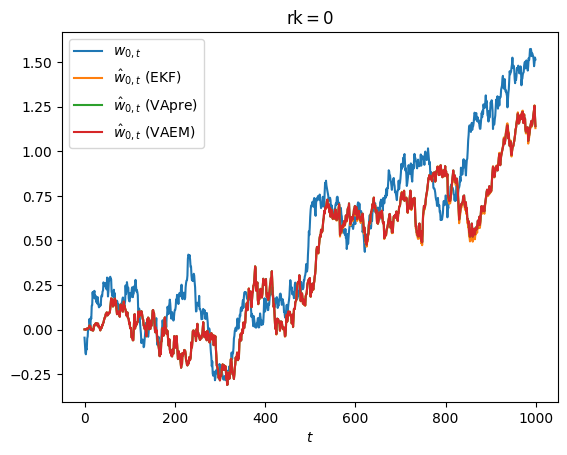

In [ ]:
#| eval: false
#| echo: false
with h5py.File(FILENAME, mode="r") as f:
  k = list(f.keys())[0]
  pg = f.require_group(k)
  N = pg.attrs["N"]
  ds_W = pg.require_dataset(name="Gen/W", shape=(N_SEED, T, N), dtype=jnp.float32)
  plt.plot(ds_W[0,:,0], label=r"$w_{0,t}$")
  for n in func_dict.keys():
    ds_W_hat = pg.require_dataset(name=f"{n}/W", shape=(N_SEED, T, N), dtype=jnp.float32)
    plt.plot(ds_W_hat[0,:,0], label=r"$\hat{w}_{0,t}$" + f" ({n})")
  plt.xlabel("$t$")
  plt.title(r"$\text{rk} = 0$")
  plt.legend()


### 結果

- $N$
- $T=1000$
- $\boldsymbol\Gamma=2^p\mathbf I$
- $\boldsymbol\Sigma=2^q\mathbf I$
- $\mathbf w_{-1}=(r/2)(1,\ldots,1)^T/\sqrt{N}$
- $\mathbf P_{-1}=\boldsymbol\Gamma$
- $\epsilon=2^{-16}$

In [ ]:
#| eval: false
#| echo: false

app = Dash(__name__)

display(Markdown(f"Listening on: [localhost:{PORTS[0]}](http://localhost:{PORTS[0]})"))

app.layout = html.Div([
    html.Div([
        dcc.Markdown(children="PRNG:", mathjax=True, style={'margin-right': '8px', 'font-weight': 'bold'}),
        dcc.Dropdown(jnp.arange(1000).tolist(), 0, id="dropdown-rs", clearable=False),
    ], style={'display': 'inline-flex', 'align-items': 'center', 'margin-right': '10px'}),


    html.Div([
        dcc.Markdown(children="dim:", mathjax=True, style={'margin-right': '8px', 'font-weight': 'bold'}),
        dcc.Dropdown([0, 1], 0, id="dropdown-dim", clearable=False),
    ], style={'display': 'inline-flex', 'align-items': 'center', 'margin-right': '10px'}),
    
    html.Div([
        dcc.Markdown(children="$N$ :", mathjax=True, style={'margin-right': '8px', 'font-weight': 'bold'}),
        dcc.Dropdown(Ns, Ns[0], id="dropdown-N", clearable=False),
    ], style={'display': 'inline-flex', 'align-items': 'center', 'margin-right': '10px'}),

    html.Div([
        dcc.Markdown(children="$p$ :", mathjax=True, style={'margin-right': '8px', 'font-weight': 'bold'}),
        dcc.Dropdown(ps.tolist(), ps[0], id="dropdown-p", clearable=False),
    ], style={'display': 'inline-flex', 'align-items': 'center', 'margin-right': '10px'}),

    html.Div([
        dcc.Markdown(children="$q$ :", mathjax=True, style={'margin-right': '8px', 'font-weight': 'bold'}),
        dcc.Dropdown(qs.tolist(), qs[0], id="dropdown-q", clearable=False),
    ], style={'display': 'inline-flex', 'align-items': 'center', 'margin-right': '10px'}),

    html.Div([
        dcc.Markdown(children="$r$ :", mathjax=True, style={'margin-right': '8px', 'font-weight': 'bold'}),
        dcc.Dropdown(rs.tolist(), rs[0], id="dropdown-r", clearable=False),
    ], style={'display': 'inline-flex', 'align-items': 'center'}),

    html.Div(id="iframe-wrapper"),

    html.Div([
        dcc.RangeSlider(min=0, max=T-1, step=1, value=[0, T-1], id="rangeslider-t", marks={i: '{}'.format(i) for i in range(0, T, T//10)})
    ]),
    html.Div(id='rangeslider-output', style={'marginTop': 10, 'marginBottom': 10, 'text-align': 'center'}),

    html.Div(id="iframe-xy"),
])

@callback(
    Output("iframe-wrapper", "children"),
    Input("dropdown-rs", "value"),
    Input("dropdown-dim", "value"),
    Input("dropdown-N", "value"),
    Input("dropdown-p", "value"),
    Input("dropdown-q", "value"),
    Input("dropdown-r", "value"),
)
def update_iframe(rs, dim, N, p, q, r):
    with h5py.File(FILENAME, mode="r") as f:
        dirparam = f"/p{N}{p}{q}{r}"
        di = dict()
        ds_W = f.require_dataset(name=f"{dirparam}/Gen/W", shape=(N_SEED, T, N), dtype=jnp.float32)
        di["True"] = ds_W[rs,:,dim]
        for n in func_dict.keys():
            ds_W = f.require_dataset(name=f"{dirparam}/{n}/W", shape=(N_SEED, T, N), dtype=jnp.float32)
            di[n] = ds_W[rs,:,dim]
        df = pd.DataFrame(di)
        df["t"] = jnp.arange(T)
        df = df.set_index("t")
    fig = px.line(df)
    fig.update_layout(
        xaxis_title="$t$",
        yaxis_title=r"$\hat w_{0,t}$",
        xaxis_title_font=dict(size=18),
        yaxis_title_font=dict(size=18),
        #legend=dict(x=0.01,y=0.99,xanchor='left',yanchor='top',orientation='h',)
    )
    # HTML スニペット（div 部分のみ）を取得
    html_snippet = fig.to_html(full_html=False, include_mathjax="cdn")

    # Iframe に埋め込む
    return html.Iframe(
        srcDoc=html_snippet,
        style={"width": "100%", "height": "500px", "border": "none"}
    )

@callback(
    Output("rangeslider-output", "children"),
    Input("rangeslider-t", "value"),
)
def update_range(ts):
    return f"[{ts[0]}, {ts[1]})"

@callback(
    Output("iframe-xy", "children"),
    Input("rangeslider-t", "value"),
    Input("dropdown-rs", "value"),
    Input("dropdown-N", "value"),
    Input("dropdown-p", "value"),
    Input("dropdown-q", "value"),
    Input("dropdown-r", "value"),
)
def update_X(ts, rs, N, p, q, r):
    with h5py.File(FILENAME, mode="r") as f:
        dirparam = f"/p{N}{p}{q}{r}"
        t0, t1 = ts
        ds_X = f.require_dataset(name=f"{dirparam}/Gen/X", shape=(N_SEED, T, N), dtype=jnp.float32)
        ds_Y = f.require_dataset(name=f"{dirparam}/Gen/Y", shape=(N_SEED, T), dtype=jnp.float32)
        df_X = pd.DataFrame(ds_X[rs,t0:t1,:2], columns=["0", "1"])
        df_X["y"] = ds_Y[rs,t0:t1].astype("int").astype("str")
    fig = px.scatter(df_X, x="0", y="1", color="y")

    fig.update_layout(
        xaxis_title="$x_0$",
        yaxis_title="$x_1$",
        xaxis_title_font=dict(size=18),
        yaxis_title_font=dict(size=18),
        #legend=dict(x=0.01,y=0.99,xanchor='left',yanchor='top',orientation='h',)
    )

    # HTML スニペット（div 部分のみ）を取得
    html_snippet = fig.to_html(full_html=False, include_mathjax="cdn")

    # Iframe に埋め込む
    return html.Iframe(
        srcDoc=html_snippet,
        style={"width": "100%", "height": "500px", "border": "none"}
    )

app.run(port=PORTS[0], jupyter_height=1200)

Listening on: [localhost:8080](http://localhost:8080)

### 誤差

$$E(\{w_{0,t}\}_{t=0,\ldots,T})=\{\hat{w}_{0,t} - w_{0,t}\}_{t=0,\ldots,T}$$

- $N$
- $T=1000$
- $\boldsymbol\Gamma=2^p\mathbf I$
- $\boldsymbol\Sigma=2^q\mathbf I$
- $\mathbf w_{-1}=(r/2)(1,\ldots,1)^T/\sqrt{N}$
- $\mathbf P_{-1}=\boldsymbol\Gamma$
- $\epsilon=2^{-16}$

In [ ]:
#| eval: false
#| echo: false
app = Dash(__name__)

display(Markdown(f"Listening on: [localhost:{PORTS[1]}](http://localhost:{PORTS[1]})"))

app.layout = html.Div([
    html.Div([
        dcc.Slider(
            min=int(math.log10(10)), 
            max=int(math.log10(N_SEED*T//100)), 
            step=0.1, 
            value=int(math.log10(100)), 
            marks={i: '{}'.format(10 ** i) for i in range(int(math.log10(N_SEED*T//10)))},
            id="slider-bin")
    ]),
    html.Div(id='slider-output', style={'marginTop': 10, 'marginBottom': 10, 'text-align': 'center'}),
    html.Div([
        dcc.Markdown(children="$N$ :", mathjax=True, style={'margin-right': '8px', 'font-weight': 'bold'}),
        dcc.Dropdown(Ns, Ns[0], id="dropdown-N", clearable=False),
    ], style={'width': '17%', 'display': 'inline-flex', 'align-items': 'center', 'margin-right': '10px'}),

    html.Div([
        dcc.Markdown(children="$p$ :", mathjax=True, style={'margin-right': '8px', 'font-weight': 'bold'}),
        dcc.Dropdown(ps.tolist(), ps[0], id="dropdown-p", clearable=False),
    ], style={'width': '15%', 'display': 'inline-flex', 'align-items': 'center', 'margin-right': '10px'}),

    html.Div([
        dcc.Markdown(children="$q$ :", mathjax=True, style={'margin-right': '8px', 'font-weight': 'bold'}),
        dcc.Dropdown(qs.tolist(), qs[0], id="dropdown-q", clearable=False),
    ], style={'width': '15%', 'display': 'inline-flex', 'align-items': 'center', 'margin-right': '10px'}),

    html.Div([
        dcc.Markdown(children="$r$ :", mathjax=True, style={'margin-right': '8px', 'font-weight': 'bold'}),
        dcc.Dropdown(rs.tolist(), rs[0], id="dropdown-r", clearable=False),
    ], style={'width': '15%', 'display': 'inline-flex', 'align-items': 'center'}),

    html.Div(id="iframe-wrapper")
])

@callback(
    Output("slider-output", "children"),
    Input("slider-bin", "value"),
)
def update_bin(log_bin):
    bin = round(10**log_bin)
    return f"Set the window size to {bin} points."

@callback(
    Output("iframe-wrapper", "children"),
    Input("slider-bin", "value"),
    Input("dropdown-N", "value"),
    Input("dropdown-p", "value"),
    Input("dropdown-q", "value"),
    Input("dropdown-r", "value"),
)
def update_iframe(log_bin, N, p, q, r):
    bin = round(10**log_bin)
    with h5py.File(FILENAME, mode="r") as f:
        dirparam = f"/p{N}{p}{q}{r}"
        di = dict()
        ds_W_True = f.require_dataset(
            name=f"{dirparam}/Gen/W", 
            shape=(N_SEED, T, N), 
            dtype=jnp.float32)[:,:,0].ravel()
        W_True_arg = ds_W_True.argpartition(jnp.arange(bin, N_SEED*T, bin))
        ds_W_True = ds_W_True[W_True_arg]
        di["w"] = ds_W_True
        for n in func_dict.keys():
            ds_W = f.require_dataset(name=f"{dirparam}/{n}/W", shape=(N_SEED, T, N), dtype=jnp.float32)
            di[n] = ds_W[:,:,0].ravel()[W_True_arg] - ds_W_True
        df = pd.DataFrame(di)
        df_groupby = df.groupby(df.index // bin)
        df_mean = df_groupby.mean()
        df_mean = df_mean.set_index("w")
        df_25 = df_groupby[list(func_dict.keys())].quantile(0.25)
        df_50 = df_groupby[list(func_dict.keys())].quantile(0.5)
        df_75 = df_groupby[list(func_dict.keys())].quantile(0.75)
    
    fig = go.Figure()
    for n, c in zip(func_dict.keys(), [simple.hex_to_rgb(S) for S in px.colors.qualitative.Plotly]):
        # 中心線
        fig.add_trace(go.Scatter(
            x=df_mean.index,
            y=df_mean[n],
            name=f"{n} (mean)",
            line=dict(color=c, dash="dash"),
            mode='lines'
        ))
        # 中心線２
        fig.add_trace(go.Scatter(
            x=df_mean.index,
            y=df_50[n],
            name=f"{n} (quantile 50%)",
            line=dict(color=c),
            mode='lines'
        ))
        # 塗りつぶし範囲
        fig.add_trace(go.Scatter(
            x=df_mean.index.tolist() + df_mean.index[::-1].tolist(),
            y=df_75[n].tolist() + df_25[n][::-1].tolist(),
            name=f"{n} (quantile 25%)",
            fill='toself',
            fillcolor=c.replace('rgb', 'rgba').replace(')', ',0.5)'),
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip"
        ))

    fig.update_layout(
        xaxis_title="$w_0$",
        yaxis_title=r"$\hat w_{0}-w_0$",
        xaxis_title_font=dict(size=18),
        yaxis_title_font=dict(size=18),
    )
    # HTML スニペット（div 部分のみ）を取得
    html_snippet = fig.to_html(full_html=False, include_mathjax="cdn")

    # Iframe に埋め込む
    return html.Iframe(
        srcDoc=html_snippet,
        style={"width": "100%", "height": "500px", "border": "none"}
    )

app.run(port=PORTS[1])

Listening on: [localhost:8081](http://localhost:8081)

In [ ]:
#| eval: false
#| echo: false
from jax.nn import sigmoid
import numpy as np

# 既存コードと同様に定義されている前提
# Ns, ps, qs, rs: ドロップダウンの候補
# func_dict: {"EKF": func, "ALS": func, ...} など、モデル名の辞書
# simple.hex_to_rgb: "#RRGGBB" → "rgb(r,g,b)" の関数

app = Dash(__name__) 

display(Markdown(f"Listening on: [localhost:{PORTS[2]}](http://localhost:{PORTS[2]})"))

app.layout = html.Div([
    html.Div([
        dcc.Slider(
            min=int(math.log10(10)),
            max=int(math.log10(N_SEED * T // 100)),
            step=0.1,
            value=int(math.log10(100)),
            marks={i: f"{10 ** i}" for i in range(int(math.log10(N_SEED * T // 10)))},
            id="slider-bin")
    ]),
    html.Div(
        id='slider-output',
        style={'marginTop': 10, 'marginBottom': 10, 'text-align': 'center'}
    ),

    html.Div([
        dcc.Markdown(children="$N$ :", mathjax=True,
                     style={'margin-right': '8px', 'font-weight': 'bold'}),
        dcc.Dropdown(Ns, Ns[0], id="dropdown-N", clearable=False),
    ], style={'width': '17%', 'display': 'inline-flex',
              'align-items': 'center', 'margin-right': '10px'}),

    html.Div([
        dcc.Markdown(children="$p$ :", mathjax=True,
                     style={'margin-right': '8px', 'font-weight': 'bold'}),
        dcc.Dropdown(ps.tolist(), ps[0], id="dropdown-p", clearable=False),
    ], style={'width': '15%', 'display': 'inline-flex',
              'align-items': 'center', 'margin-right': '10px'}),

    html.Div([
        dcc.Markdown(children="$q$ :", mathjax=True,
                     style={'margin-right': '8px', 'font-weight': 'bold'}),
        dcc.Dropdown(qs.tolist(), qs[0], id="dropdown-q", clearable=False),
    ], style={'width': '15%', 'display': 'inline-flex',
              'align-items': 'center', 'margin-right': '10px'}),

    html.Div([
        dcc.Markdown(children="$r$ :", mathjax=True,
                     style={'margin-right': '8px', 'font-weight': 'bold'}),
        dcc.Dropdown(rs.tolist(), rs[0], id="dropdown-r", clearable=False),
    ], style={'width': '15%', 'display': 'inline-flex',
              'align-items': 'center'}),

    html.Div(id="iframe-wrapper")
])

@callback(
    Output("slider-output", "children"),
    Input("slider-bin", "value"),
)
def update_bin(log_bin):
    bin_size = round(10 ** log_bin)
    return f"Set the window size to {bin_size} points."


@callback(
    Output("iframe-wrapper", "children"),
    Input("slider-bin", "value"),
    Input("dropdown-N", "value"),
    Input("dropdown-p", "value"),
    Input("dropdown-q", "value"),
    Input("dropdown-r", "value"),
)
def update_iframe(log_bin, N, p, q, r):
    bin_size = round(10 ** log_bin)

    with h5py.File(FILENAME, mode="r") as f:
        # 00_Data.h5 の構造に合わせる
        dir_base = f"/p{N}{p}{q}{r}"
        dir_gen  = f"{dir_base}/Gen"

        # 真の w と X を読み込み
        # Gen/W : (N_SEED, T, N), Gen/X : (N_SEED, T, N)
        W_true_all = f.require_dataset(
            name=f"{dir_gen}/W",
            shape=(N_SEED, T, N),
            dtype=jnp.float32
        )[...]
        X_all = f.require_dataset(
            name=f"{dir_gen}/X",
            shape=(N_SEED, T, N),
            dtype=jnp.float32
        )[...]

        # t=1..T-1 の w_t, x_t と t=0..T-2 の \hat w_{t-1} を対応させる
        W_true_t = W_true_all[:, 1:, :]   # (N_SEED, T-1, N)
        X_t      = X_all[:, 1:, :]        # (N_SEED, T-1, N)

        # 真の確率 σ(w_t^T x_t)
        z_true = jnp.einsum("ijk,ijk->ij", W_true_t, X_t)   # (N_SEED, T-1)
        p_true = sigmoid(z_true).ravel()                    # (N_SEED*(T-1),)

        # 並べ替えの基準として w_{0,t} を使う
        w0_true = W_true_t[:, :, 0].ravel()
        n_points = w0_true.shape[0]

        if bin_size > n_points:
            bin_size = int(n_points)

        # 元コードに倣って argpartition でビン境界を作る
        partition_indices = jnp.arange(bin_size, n_points, bin_size)
        order = w0_true.argpartition(partition_indices)

        # 並べ替え
        w0_sorted   = np.array(w0_true[order])
        p_true_sorted = np.array(p_true[order])

        # DataFrame: x 軸用 w と、各手法の二乗誤差を入れる
        di = {"w": w0_sorted}

        # 各手法について
        for name in func_dict.keys():
            # 予測された W (N_SEED, T, N)
            W_est_all = f.require_dataset(
                name=f"{dir_base}/{name}/W",
                shape=(N_SEED, T, N),
                dtype=jnp.float32
            )[...]

            # t-1 の推定 w と t の X を組み合わせる
            W_est_tm1 = W_est_all[:, :-1, :]          # (N_SEED, T-1, N)
            z_est = jnp.einsum("ijk,ijk->ij", W_est_tm1, X_t)  # (N_SEED, T-1)
            p_est = sigmoid(z_est).ravel()

            p_est_sorted = np.array(p_est[order])

            # 点ごとの sq error
            sq_err = (p_true_sorted - p_est_sorted) ** 2
            di[name] = sq_err

        df = pd.DataFrame(di)
        df_groupby = df.groupby(df.index // bin_size)

        # ビン代表の w (平均)
        df_mean = df_groupby.mean()   # "w" + 各手法の平均二乗誤差
        w_bin = df_mean["w"]

        cols = list(func_dict.keys())

        # MSE と四分位（まだ平方根をとっていない）
        df_mse = df_mean[cols]
        df_q25 = df_groupby[cols].quantile(0.25)
        df_q50 = df_groupby[cols].quantile(0.50)
        df_q75 = df_groupby[cols].quantile(0.75)

        # E = sqrt(MSE), 四分位も √ を取る
        df_E_mean = np.sqrt(df_mse)
        df_E_25   = np.sqrt(df_q25)
        df_E_50   = np.sqrt(df_q50)
        df_E_75   = np.sqrt(df_q75)

    # Plotly 図を作成
    fig = go.Figure()
    colors = [simple.hex_to_rgb(c) for c in px.colors.qualitative.Plotly]

    for name, c in zip(func_dict.keys(), colors):
        # 平均 E (破線)
        fig.add_trace(go.Scatter(
            x=w_bin,
            y=df_E_mean[name],
            name=f"{name} (mean E)",
            line=dict(color=c, dash="dash"),
            mode="lines"
        ))

        # 中央値 E (実線)
        fig.add_trace(go.Scatter(
            x=w_bin,
            y=df_E_50[name],
            name=f"{name} (median E)",
            line=dict(color=c),
            mode="lines"
        ))

        # IQR の塗りつぶし
        fig.add_trace(go.Scatter(
            x=w_bin.tolist() + w_bin[::-1].tolist(),
            y=df_E_75[name].tolist() + df_E_25[name][::-1].tolist(),
            name=f"{name} (IQR of E)",
            fill="toself",
            fillcolor=c.replace("rgb", "rgba").replace(")", ",0.3)"),
            line=dict(color="rgba(255,255,255,0)"),
            hoverinfo="skip"
        ))

    fig.update_layout(
        xaxis_title="$w_0$",
        yaxis_title=(
            r"$E = \sqrt{\frac{1}{T}\sum_t"
            r"\left(\sigma(w_t^\top x_t)-\sigma(\hat w_{t-1}^\top x_t)\right)^2}$"
        ),
        xaxis_title_font=dict(size=18),
        yaxis_title_font=dict(size=18),
        legend_title="Method"
    )

    html_snippet = fig.to_html(full_html=False, include_mathjax="cdn")

    return html.Iframe(
        srcDoc=html_snippet,
        style={"width": "100%", "height": "500px", "border": "none"}
    )

app.run(port=PORTS[2])


Listening on: [localhost:8082](http://localhost:8082)

In [ ]:
#| eval: false
#| echo: false

rows = []  # DataFrame の行をためる

with h5py.File(FILENAME, mode="r") as f:
    N = Ns[0]
    q = qs[0]
    r = rs[0]

    for p in ps:
        dirparam = f"/p{N}{p}{q}{r}"
        true_P = (2.0 ** p) * jnp.eye(N, dtype=jnp.float32)
        true_norm = float(jnp.sqrt(jnp.sum(true_P ** 2)))

        for name in func_dict.keys():
            dset_path = f"{dirparam}/{name}/P"
            if dset_path not in f:
                print(f"[WARN] {dset_path} not found, skip.")
                continue

            # shape: (N_SEED, T, N, N)
            ds_P = jnp.array(f[dset_path])

            # ---- 高速版：平均行列で比較 ----
            P_mean = jnp.mean(ds_P, axis=(0, 1))  # (N, N)

            diff = P_mean - true_P
            frob_err = float(jnp.sqrt(jnp.sum(diff ** 2)))
            rel_err = frob_err / true_norm

            rows.append({
                "p": p,
                "algorithm": name,
                "frob_error": frob_err,
                "relative_error": rel_err
            })

# DataFrame 化
df = pd.DataFrame(rows).set_index("p")
df


,algorithm,frob_error,relative_error
p,,,
-4,EKF,2.979151,33.705244
-4,VApre,1.796990,20.330618
-4,VAEM,1.792639,20.281393
-6,EKF,0.973215,44.042689
-6,VApre,0.778222,35.218304
-6,VAEM,0.777547,35.187783
-8,EKF,0.380470,68.872392
-8,VApre,0.352851,63.872866
-8,VAEM,0.352767,63.857691


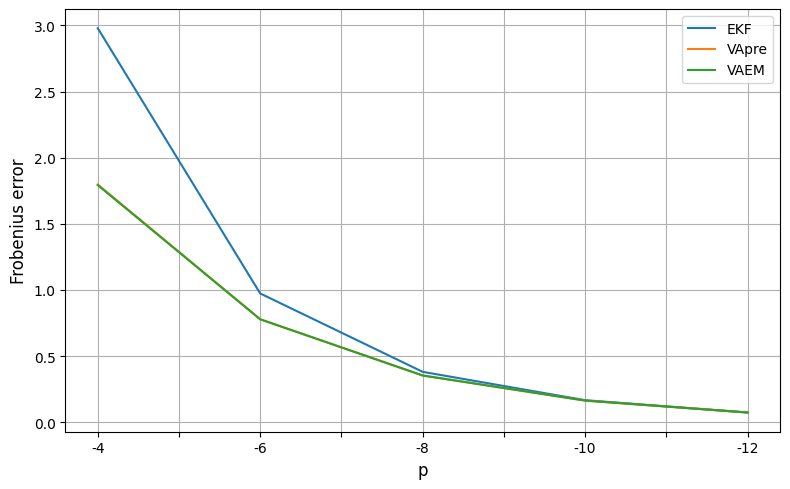

In [ ]:
#| eval: false
#| echo: false
plt.figure(figsize=(8, 5))

ax = df[df["algorithm"] == "EKF"]["frob_error"].plot(label="EKF")
df[df["algorithm"] == "VApre"]["frob_error"].plot(ax=ax, label="VApre")
df[df["algorithm"] == "VAEM"]["frob_error"].plot(ax=ax, label="VAEM")

# ---- ここでラベル等を設定 ----
ax.set_xlabel("p", fontsize=12)
ax.set_ylabel("Frobenius error", fontsize=12)
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

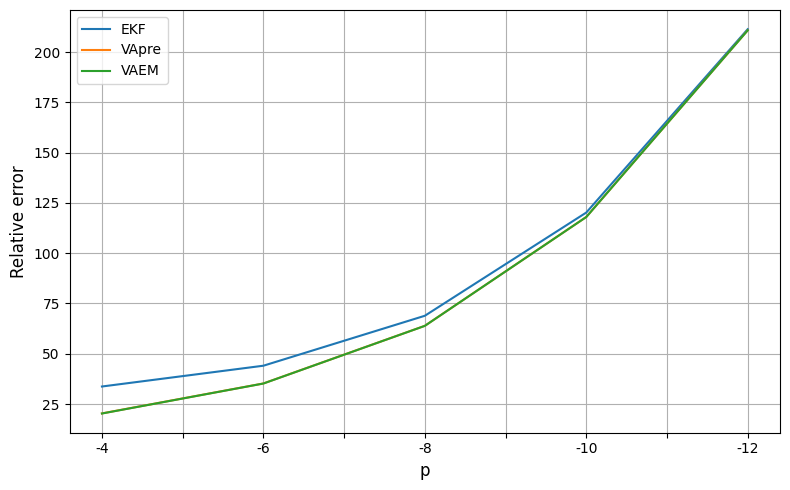

In [ ]:
#| eval: false
#| echo: false
plt.figure(figsize=(8, 5))

ax = df[df["algorithm"] == "EKF"]["relative_error"].plot(label="EKF")
df[df["algorithm"] == "VApre"]["relative_error"].plot(ax=ax, label="VApre")
df[df["algorithm"] == "VAEM"]["relative_error"].plot(ax=ax, label="VAEM")

# ---- ここでラベル等を設定 ----
ax.set_xlabel("p", fontsize=12)
ax.set_ylabel("Relative error", fontsize=12)
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

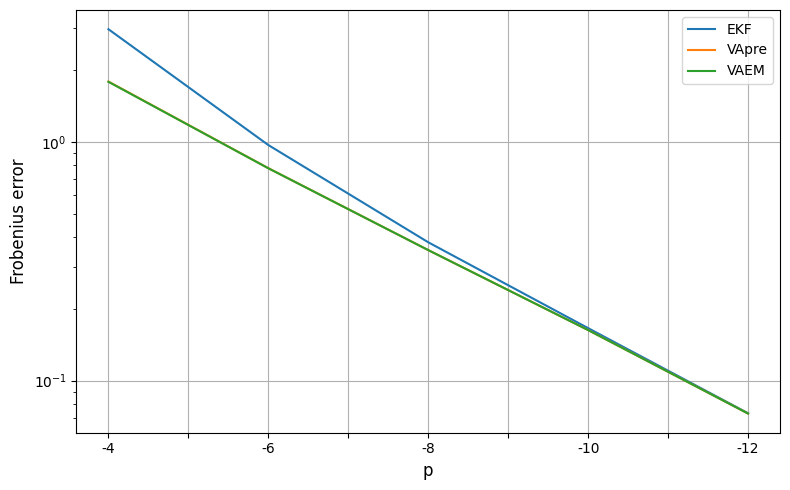

In [ ]:
#| eval: false
#| echo: false
plt.figure(figsize=(8, 5))

ax = df[df["algorithm"] == "EKF"]["frob_error"].plot(label="EKF", logy=True)
df[df["algorithm"] == "VApre"]["frob_error"].plot(ax=ax, label="VApre", logy=True)
df[df["algorithm"] == "VAEM"]["frob_error"].plot(ax=ax, label="VAEM", logy=True)

# ---- ここでラベル等を設定 ----
ax.set_xlabel("p", fontsize=12)
ax.set_ylabel("Frobenius error", fontsize=12)
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

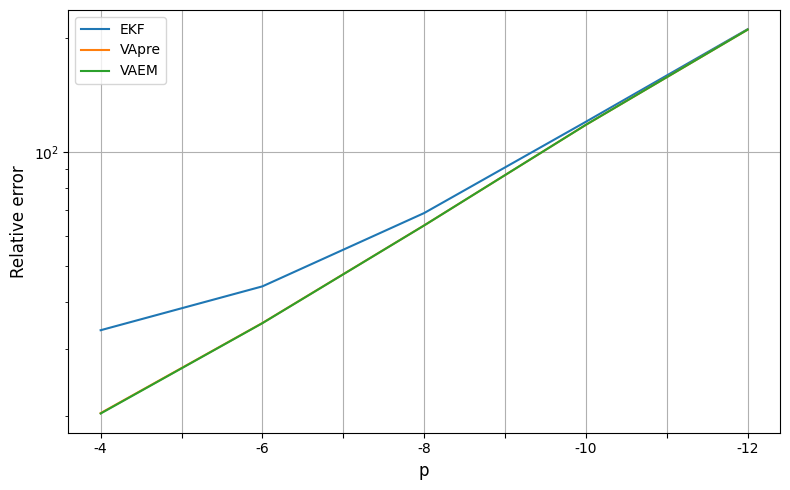

In [ ]:
#| eval: false
#| echo: false
plt.figure(figsize=(8, 5))

ax = df[df["algorithm"] == "EKF"]["relative_error"].plot(label="EKF", logy=True)
df[df["algorithm"] == "VApre"]["relative_error"].plot(ax=ax, label="VApre", logy=True)
df[df["algorithm"] == "VAEM"]["relative_error"].plot(ax=ax, label="VAEM", logy=True)

# ---- ここでラベル等を設定 ----
ax.set_xlabel("p", fontsize=12)
ax.set_ylabel("Relative error", fontsize=12)
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()